<a href="https://colab.research.google.com/github/map72ru/python_data_lib/blob/main/MikhaylovAP_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовой проект для курса "Python для Data Science"

#### Задание:

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).


Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.65
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).


#### Загрузка данных

In [1]:
# Загрузим обучающую выборку

from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
train = pd.read_csv('//content/gdrive/My Drive/data/train.csv')
test = pd.read_csv('//content/gdrive/My Drive/data/test.csv')

Mounted at /content/gdrive


In [2]:
# Статистика для обучающей выборки
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [3]:
# Статистика по целевой выборке

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [4]:
train.describe()

Id    DistrictId  ...       Shops_1          Price
count  10000.00000  10000.000000  ...  10000.000000   10000.000000
mean    8383.40770     50.400800  ...      4.231300  214138.857399
std     4859.01902     43.587592  ...      4.806341   92872.293865
min        0.00000      0.000000  ...      0.000000   59174.778028
25%     4169.50000     20.000000  ...      1.000000  153872.633942
50%     8394.50000     36.000000  ...      3.000000  192269.644879
75%    12592.50000     75.000000  ...      6.000000  249135.462171
max    16798.00000    209.000000  ...     23.000000  633233.466570

[8 rows x 17 columns]

Исследуем выборку на выбросы

Выводы;
1.    Существуют категориальные признаки: Ecology_2, Ecology_3, Shops_2
2.   Значения Floor, HouseFloor, HouseYear, Rooms имеют тип float64, хотя достаточно int32
3.   Отсутствуют данные в колонках LifeSquare, Healthcare_1
4.   Существуют ошибки в данных: 
    - Год постройки не может 20052010 (возможны и другие ошибки)
    - Признак Social_2 имеет явный выброс
    - Минимальное значение площадей имеют выбросы
    - Количество комнат не может быть равным 0
    - В сумме Жилая площадь и Площадь кухни не могут быть больше общей площади
    - Существуют значения этажей равные 0 и 117

### Доработка тренировочной выборки

#### Замена категориальных признаков на числовые

Значения категориальных признаков:

In [5]:
print(train['Ecology_2'].value_counts())
print(train['Ecology_3'].value_counts())
print(train['Shops_2'].value_counts())

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


Категориальные признаки имеют только два значения. Можно их заменить на бинарное значение

In [6]:
def replace_Category(df, attribute):
  df.replace({attribute : {'A':0, 'B': 1}}, inplace=True)

In [7]:
replace_Category(train, 'Ecology_2')
replace_Category(train, 'Ecology_3')
replace_Category(train, 'Shops_2')

replace_Category(test, 'Ecology_2')
replace_Category(test, 'Ecology_3')
replace_Category(test, 'Shops_2')

In [8]:
# Проверим, что больше нет категориальных признаков
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

#### Изменение типа значений для атрибутов

In [9]:
# Изменим типы значений для атрибутов Floor, HouseFloor, HouseYear

train['Floor'] = train['Floor'].astype('int64', False)
train['HouseFloor'] = train['HouseFloor'].astype('int64', False)
train['HouseYear'] = train['HouseYear'].astype('int64', False)
train['Rooms'] = train['Rooms'].astype('int64', False)

test['Floor'] = test['Floor'].astype('int64', False)
test['HouseFloor'] = test['HouseFloor'].astype('int64', False)
test['HouseYear'] = test['HouseYear'].astype('int64', False)
test['Rooms'] = test['Rooms'].astype('int64', False)


train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  int64  
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

#### Заполнение отсутствующих значений

Поскольку атрибут HealthCare_1 не имеет смыслового описания и у него пропущено ~50% значений, то исключим данный атрибут из анализа

In [10]:
train.drop('Healthcare_1', axis=1, inplace=True)
test.drop('Healthcare_1', axis=1, inplace=True)

Рассчитаем коэффициент отношения LifeSquare к Squre для всех не пустых значений LifeSquare и исключив явные выбросы. В качестве допущения примем, что минимальное значение атрибута LifeSquare равно 4, максимальное - 700

In [11]:
# Функция заполняет пустые значения и выбросы для атрибута LifeSquare через общую площадь квартиры.
def repaire_lifeSquare(df, coeff = None):
  lifeSquare = df['LifeSquare']
  lifeSquare_not_null = lifeSquare.dropna()
  if coeff is None:
    coeff = lifeSquare_not_null.loc[lifeSquare_not_null.between(4, 700)].mean() / df['Square'].mean()
  df.loc[df['LifeSquare'].between(4, 700) == False, 'LifeSquare'] = coeff * df['Square']
  return coeff

In [12]:
# Выполним замену
coef = repaire_lifeSquare(train)
repaire_lifeSquare(test, coef)

0.6527160218535656

In [13]:
train['LifeSquare'].describe()

count    10000.000000
mean        37.331690
std         18.993954
min          1.298215
25%         25.285945
50%         33.735618
75%         45.224840
max        638.163193
Name: LifeSquare, dtype: float64

#### Исправление года постройка дома

In [14]:
import numpy as np

# Функция исправляет год постройки недвижимости на среднее значение (Примем в качестве ограничения текущий год, т.к. не знаем, когда была сделана выборка)
def repaire_houseYear(df):
  my = np.round(df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean())
  df.loc[df['HouseYear'] > 2020, 'HouseYear'] = my

In [15]:
repaire_houseYear(train)
repaire_houseYear(test)

In [16]:
train['HouseYear'].describe()

count    10000.000000
mean      1984.865400
std         18.409644
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64

#### Исключение выбросов в атрибуте Social_2

In [17]:
# Функция считает межквантильное расстояние
def interquantile_distance(desc):
  return (desc['25%'] - 1.5 * (desc['75%'] - desc['25%']), desc['75%'] + 1.5 * (desc['75%'] - desc['25%']))

In [18]:
# Посмотрим на значения выбросов атрибута

train.loc[train['Social_2'] > interquantile_distance(train['Social_2'].describe())[1]].describe()

Id  DistrictId       Rooms  ...  Shops_1  Shops_2          Price
count    176.000000  176.000000  176.000000  ...    176.0    176.0     176.000000
mean    8671.528409   17.386364    1.988636  ...     15.0      1.0  237960.565102
std     4826.684818   13.827866    1.079622  ...      0.0      0.0   77638.124894
min       14.000000   12.000000    1.000000  ...     15.0      1.0   71319.376419
25%     4209.000000   12.000000    1.000000  ...     15.0      1.0  180652.304478
50%     8694.500000   13.000000    2.000000  ...     15.0      1.0  228453.854181
75%    12756.250000   13.000000    3.000000  ...     15.0      1.0  289880.215630
max    16673.000000   57.000000   10.000000  ...     15.0      1.0  622888.825328

[8 rows x 19 columns]

Поскольку максимальное значение атрибута Social_2 однозначно соответствует другим значениям атрибутов Ecology_1,	Ecology_2,	Ecology_3,	Social_1,	Social_2,	Social_3,	Healthcare_1,	Helthcare_2,	Shops_1,	Shops_2 и относится, практически, только к двум округам с id=12 и 13, то будем это считать такой особенностью данных и оставим значения как есть 

#### Исправление минимальных значений площадей

Примем за минимальный размер площади квартиры - 10 кв.м (если данные даны в квадратных метрах). 

In [19]:
# Какие строки имеют значения менее 10 м2

train.loc[train['Square'] < 10]

Id  DistrictId  Rooms  ...  Shops_1  Shops_2          Price
212    1748          88      2  ...        9        1  412511.088764
1316  11526          27      1  ...        0        1  107604.269441
1608  10202           6      1  ...        0        1  137597.601458
3280  10527          27      1  ...        1        1   97560.720383
3413   9487           5      1  ...        5        1  369472.403061
4853   3224          27      0  ...        0        1  126596.941798
4900   4504          27      3  ...        1        1  161379.067034
6392  14786           1      1  ...        1        1  181434.825589
8030  13265           1      3  ...        1        1  237716.681261
8283  15744          34      1  ...       11        1  458378.777006
9294   6782          45      1  ...        2        1  438005.182323
9613   7657          38      1  ...        7        1  483283.488083

[12 rows x 19 columns]

Строки с Square < 10 и LifeSquare < 10 являются явно ошибочными, поэтому их удалим, оставшиеся значения пересчитаем через среднее отношение между Square и LifeSquare

In [20]:
train.drop(train[(train['Square'] < 10) & (train['LifeSquare'] < 10)].index, inplace=True)

In [21]:
validData = train[train['Square'] > train['LifeSquare']][['Square', 'LifeSquare']]
ratio = (validData['LifeSquare']/validData['Square']).mean()


In [22]:
train.loc[train['Square'] < 10, 'Square'] = ratio * train['LifeSquare']
test.loc[test['Square'] < 10, 'Square'] = ratio * test['LifeSquare']

#### Исправление количества комнат

In [23]:
# Строки с количеством комнат = 0

train.loc[train['Rooms'] == 0]

Id  DistrictId  Rooms  ...  Shops_1  Shops_2          Price
1397  12638          27      0  ...        0        1  268394.744389
1981   7917          27      0  ...        1        1  302211.260887
2269   7317          27      0  ...        1        1   98129.976788
3911    770          28      0  ...        0        1  217009.338463
4366    456           6      0  ...        0        1  212864.799112
6149   3159          88      0  ...        9        1  158998.110646
8834   9443          27      0  ...        1        1  219281.918007

[7 rows x 19 columns]

In [24]:
# Замена количества комнат на основе модели линейной регрессии
from sklearn.linear_model import LinearRegression

def replace_rooms(df, lr = None):
  tempData = df[df['Rooms'] != 0][['Rooms', 'LifeSquare']]
  df.reindex()

  if lr is None:
    lr = LinearRegression()
    lr.fit(tempData['LifeSquare'].values.reshape(-1, 1), tempData['Rooms'])

  y_temp = lr.predict(df[df['Rooms'] == 0]['LifeSquare'].values.reshape(-1, 1))

  y_temp = y_temp.round()
  y_temp.astype('int64')

  n = 0
  for val in df['Rooms'].index:
    if df['Rooms'][val] == 0:
      df.loc[val, 'Rooms'] = y_temp[n]
      n = n+1
  return lr

In [25]:
# Сделаем замену
lr = replace_rooms(train)
replace_rooms(test, lr)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
# Проверим результат
train['Rooms'].describe()

count    9991.000000
mean        1.893204
std         0.839172
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        19.000000
Name: Rooms, dtype: float64

In [27]:
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Построение графика по двум признакам.
def scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()

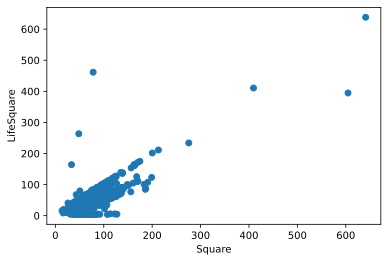

In [28]:
scatter('Square', 'LifeSquare', train)

Из графика видно, что есть ошибки в данных: значение LifeSquare не может быть больше Square.
 

In [29]:
# Проверим условие Square >= LifeSquare
invalidSquare = train.loc[train['LifeSquare'] > train['Square']]
invalidSquare

Id  DistrictId  Rooms  ...  Shops_1  Shops_2          Price
28     8054          23    1.0  ...        0        1   95338.198549
44    10521          38    3.0  ...        7        1  435462.048070
52     2301           1    2.0  ...        1        1  199215.452229
123    8753          25    3.0  ...       11        1  309688.592681
153    9870          62    1.0  ...        0        0  131797.472284
...     ...         ...    ...  ...      ...      ...            ...
9884     41          30    2.0  ...       23        1  126281.142781
9889  12918          23    2.0  ...        0        1   88150.012510
9895   2737          27    3.0  ...        0        1  234194.837047
9902  14001          73    1.0  ...        5        1  381937.404161
9910  16568          27    4.0  ...        4        1  528560.506016

[474 rows x 19 columns]

Попробуем на основе линейной регрессии рассчитать возможные значения 

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

def replace_lifeSquare(df, lr = None):
  validSquare = df.loc[df['LifeSquare'] < df['Square']]
  validSquare.drop(['Rooms', 'KitchenSquare', 'Floor', 'HouseFloor', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1',	'Shops_2'], axis=1, inplace=True)
  if 'Price' in validSquare:
    validSquare.drop('Price', axis=1, inplace=True)

  lifeSquare = validSquare['LifeSquare']
  X = validSquare.drop('LifeSquare', axis=1)

  scaler = StandardScaler()
  validSquare_scaled = scaler.fit_transform(X, lifeSquare)

  if lr is None:
    lr = LinearRegression()
    lr.fit(validSquare_scaled, lifeSquare)

    liveSquareValid_pred = lr.predict(validSquare_scaled)

    r2 = r2_score(lifeSquare, liveSquareValid_pred)
    print('R2=', r2)

  invalidSquare = df.loc[df['LifeSquare'] > df['Square']]
  invalidSquare = invalidSquare.drop(['Rooms', 'KitchenSquare', 'Floor', 'HouseFloor', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1',	'Shops_2'], axis=1)
  if 'Price' in invalidSquare:
    invalidSquare.drop('Price', axis=1, inplace=True)
  X = invalidSquare.drop('LifeSquare', axis=1)
  invalidSquare_scaled = scaler.fit_transform(X)

  lifeSquare_pred = lr.predict(invalidSquare_scaled)
  invalidSquare.loc[:, 'LifeSquare'] = lifeSquare_pred

  for i in invalidSquare.index:
    df.loc[i, 'LifeSquare'] = invalidSquare.loc[i, 'LifeSquare']

  return lr

In [31]:
lr = replace_lifeSquare(train)
replace_lifeSquare(test, lr)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


R2= 0.7700993763287868


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
train.loc[train['LifeSquare'] > train['Square']]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Helthcare_2, Shops_1, Shops_2, Price]
Index: []

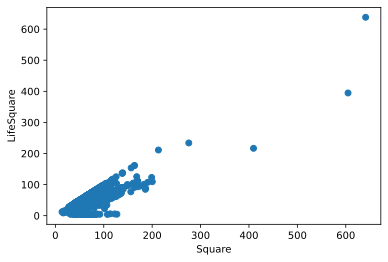

In [33]:
scatter('Square', 'LifeSquare', train)

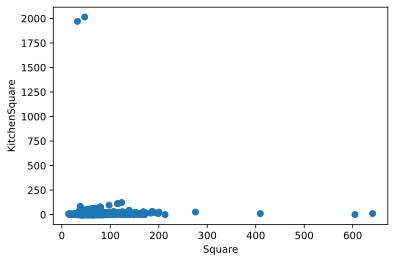

In [34]:
# Анализ отношения общей площади к площади кухни
scatter('Square', 'KitchenSquare', train)

Имеются выбросы, поэтому заменим данные значения на средние

In [35]:
# Замена выбросов на среднее значение по признаку
def replace_on_mean(df, column, mean = None):
    low, high = interquantile_distance(df[column].describe())
    if mean is None:
      mean = df[column].mean()
    
    print(f'For column {column} low: {low}, high: {high}, mean: {mean}')

    index_to_replace = df[(df[column]<low) | (df[column]>high)].index

    df.loc[index_to_replace, column] = mean
    print(f'For column {column} was replaced {index_to_replace.size} rows')

In [36]:
mean = replace_on_mean(train, 'KitchenSquare')
replace_on_mean(test, 'KitchenSquare', mean)

For column KitchenSquare low: -11.0, high: 21.0, mean: 6.278150335301771
For column KitchenSquare was replaced 47 rows
For column KitchenSquare low: -11.0, high: 21.0, mean: 5.9768
For column KitchenSquare was replaced 19 rows


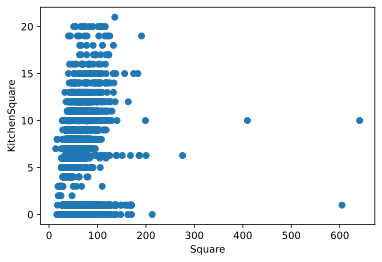

In [37]:
scatter('Square', 'KitchenSquare', train)

Рассмотрим параметры 'Floor' и  'HouseFloor'

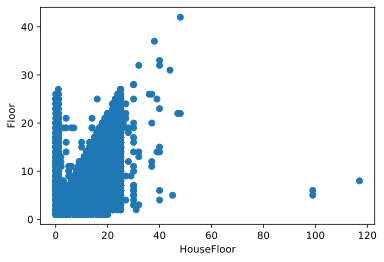

In [38]:
scatter('HouseFloor', 'Floor', train)

Нулевой этаж, значения этажей больше чем этажность дома и значения этаэей более 80 заменим на случайное значение, лежащее в диапазоне от 1 до кол-ва этажей в доме

In [39]:
import random
def replace_Floor(df):
  meanHouseFlour = df.loc[(df['HouseFloor'] > 0) | (df['HouseFloor'] <= 80)].groupby('DistrictId').agg({'HouseFloor': 'mean'})
  meanHouseFlour.index.astype('int64', False)
  meanHouseFlour = meanHouseFlour['HouseFloor'].round(0)

  invalidData = df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] > 80)]
  for index, row in invalidData.iterrows():
    df.loc[index, 'HouseFloor'] = meanHouseFlour.loc[row['DistrictId']]
  invalidDataIndex = df.loc[(df['Floor'] > df['HouseFloor'])].index
  df.loc[invalidDataIndex, 'Floor'] = df.loc[invalidDataIndex, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [40]:
replace_Floor(train)
replace_Floor(test)

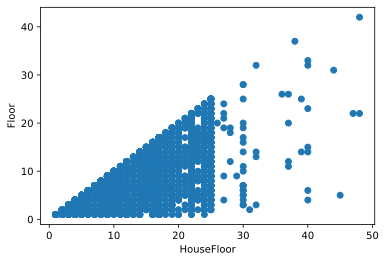

In [41]:
scatter('HouseFloor', 'Floor', train)

Ради интереса, посмотрим какое значение метрики дадут предсказания на выборке без дополнительных атрибутов

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = train.drop('Price', axis=1)
y = train['Price']

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)


In [43]:
#Линейная регрессия
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

print('R2=', r2)

R2= 0.48314812103953697


In [44]:
#Случайный лес
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=20, 
                               max_features=10, 
                               n_estimators=100,
                               random_state=42)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('R2=', r2)

R2= 0.7086805504030383


In [45]:
# Повышение градиента
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.drop(['Ecology_2', 'Ecology_3', 'DistrictId', 'Shops_2', 'Helthcare_2'], axis=1, inplace=True)
X_test.drop(['Ecology_2', 'Ecology_3', 'DistrictId', 'Shops_2', 'Helthcare_2'], axis=1, inplace=True)

from sklearn.ensemble import GradientBoostingRegressor

busting = GradientBoostingRegressor()
busting.fit(X_train, y_train)
y_pred = busting.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('R2=', r2)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


R2= 0.7218141417431111


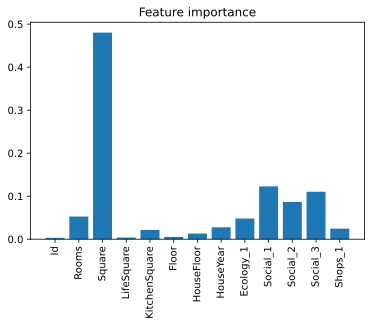

In [47]:
plt.bar(X_train.columns, busting.feature_importances_)
plt.title('Feature importance')
plt.xticks(rotation='vertical')
plt.show()

In [48]:
result = pd.DataFrame({'Model': ['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor'], 
                       'r2': [0.48314812103953697, 0.7086805504030383, 0.7218141417431111]})
result

Model        r2
0           LinearRegression  0.483148
1      RandomForestRegressor  0.708681
2  GradientBoostingRegressor  0.721814

### Добавим синтетических переменных

Количество квартир по районам

In [49]:
def add_district_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'district_info'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['district_info'] = df['district_info'].fillna(0)
    return df

In [52]:
train_modification = add_district_info(train)
test_modification = add_district_info(test)


Средняя цена за комнату

In [53]:
def add_mean_price_on_room(df, df_train=train):
    mean = df_train['Price'].mean()
    price_mean_by_room = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'price_mean_by_room'})
    df = pd.merge(df, price_mean_by_room, on='Rooms', how='left')
    df['price_mean_by_room'] = df['price_mean_by_room'].fillna(mean)
    return df

In [54]:
train_modification = add_mean_price_on_room(train_modification, train_modification)
test_modification = add_mean_price_on_room(test_modification, train_modification)

Средняя цена за комнату по району

In [55]:
def add_mean_price_on_room_by_district(df, df_train=train):
    means = df_train.groupby('DistrictId', as_index=False).agg({'Price': 'mean'})
    price_mean_by_room = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'price_mean_by_room_by_district'})
    df = pd.merge(df, price_mean_by_room, on=['DistrictId', 'Rooms'], how='left')
    for index, row in df.iterrows():
      if row['price_mean_by_room_by_district'] is None:
        df.loc[index, 'price_mean_by_room_by_district'] = means.loc['DistrictId' == row['DistrictId']]
# Оказалось, что в тестовой выборке есть номера районов, которых нет в обучающей выборке, поэтому их просто заменим на среднее
    df['price_mean_by_room_by_district'].fillna(means['Price'].mean(), inplace=True)   
    return df

In [56]:
train_modification = add_mean_price_on_room_by_district(train_modification, train_modification)
test_modification = add_mean_price_on_room_by_district(test_modification, train_modification)

Кластеризация по годам постройки дома

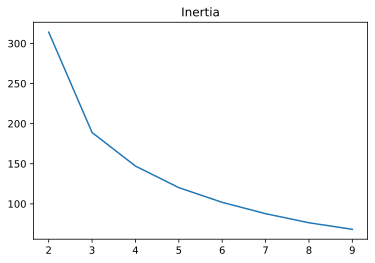

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

scaler = MinMaxScaler()
train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_modification.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])

inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_cluster_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)
plt.title('Inertia')

plt.show()

Text(0.5, 1.0, 'Train data')

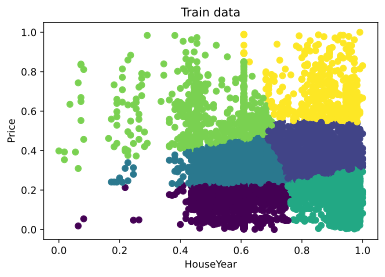

In [58]:
kmeans = KMeans(n_clusters=6, random_state=100)
year_clusters = kmeans.fit_predict(train_cluster_scaled)
plt.scatter(train_cluster_scaled['HouseYear'],
            train_cluster_scaled['Price'], c=year_clusters)

plt.xlabel('HouseYear')
plt.ylabel('Price')

plt.title('Train data')

In [59]:

def add_cluster_year(df):
    df_scaled = pd.DataFrame(scaler.fit_transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['cluster_year'] = kmeans.fit_predict(df_scaled)
    return df

In [60]:
train_modification = add_cluster_year(train_modification)
test_modification = add_cluster_year(test_modification)

### Формирование результата работы модели (предсказания)

Из базового варианта видно, что линейная регрессия сильно проигрывает по метрике r2, поэтому не будем ее рассматривать

In [64]:
X = train_modification.drop('Price', axis=1)
y = train_modification['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [65]:
forest = RandomForestRegressor(max_depth=20, 
                               max_features=10, 
                               n_estimators=100,
                               random_state=42)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('R2=', r2)

R2= 0.753076406051497


In [70]:
# Повышение градиента
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.drop(['Ecology_2', 'Ecology_3', 'DistrictId', 'Shops_2', 'Helthcare_2'], axis=1, inplace=True)
X_test.drop(['Ecology_2', 'Ecology_3', 'DistrictId', 'Shops_2', 'Helthcare_2'], axis=1, inplace=True)

busting = GradientBoostingRegressor()
busting.fit(X_train, y_train)
y_pred = busting.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('R2=', r2)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


R2= 0.7837972255540415


Видно, что алгоритм повышения градиента дает лучший прогноз, поэтому используем его

In [74]:
x_test = test_modification.drop(['Ecology_2', 'Ecology_3', 'DistrictId', 'Shops_2', 'Helthcare_2'], axis=1)
price_predict = busting.predict(x_test)
price_predict

array([158879.68413492, 263443.4394743 , 238166.80439093, ...,
       325922.76558228, 200006.23448031, 202662.15071531])

In [78]:
pd.DataFrame({ 'Id': test['Id'], 'Price': price_predict }).to_csv('//content/gdrive/My Drive/data/MihailovAP_prediction.csv', index=None)